# Install and Load Libraries/Data

In [1]:
import os
import random
from concurrent.futures import ThreadPoolExecutor
from glob import glob
import joblib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pyarrow.parquet as pq
import seaborn as sns
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import mutual_info_classif
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import (accuracy_score, auc, classification_report, 
                             cohen_kappa_score, confusion_matrix, make_scorer, 
                             roc_curve, RocCurveDisplay, ConfusionMatrixDisplay)
from sklearn.model_selection import (GridSearchCV, StratifiedKFold, 
                                     train_test_split)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (FunctionTransformer, OneHotEncoder, 
                                    OrdinalEncoder, StandardScaler)
from sklearn.utils.class_weight import compute_class_weight
from skorch import NeuralNetClassifier
from torch import nn
import torch
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm

# Set the seed for reproducibility
def set_seed(seed=22):
    np.random.seed(seed)
    random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

set_seed(22)

os.environ["PYTHONWARNINGS"] = "ignore"

In [2]:
train_csv_path = './data/train.csv'
test_csv_path = './data/test.csv'
series_train_path = './data/series_train.parquet'
series_test_path = './data/series_test.parquet'

# Load the CSV files
train_df = pd.read_csv(train_csv_path)
test_df = pd.read_csv(test_csv_path)
train_df = train_df[train_df['sii'].notna()].copy()

In [3]:
def feature_engineering(df):
    """
    Apply feature engineering transformations to the DataFrame.
    """
    df['BMI_Age'] = df['Physical-BMI'] * df['Basic_Demos-Age']
    df['Internet_Hours_Age'] = df['PreInt_EduHx-computerinternet_hoursday'] * df['Basic_Demos-Age']
    df['BMI_Internet_Hours'] = df['Physical-BMI'] * df['PreInt_EduHx-computerinternet_hoursday']
    df['BFP_BMI'] = df['BIA-BIA_Fat'] / df['BIA-BIA_BMI']
    df['FFMI_BFP'] = df['BIA-BIA_FFMI'] / df['BIA-BIA_Fat']
    df['FMI_BFP'] = df['BIA-BIA_FMI'] / df['BIA-BIA_Fat']
    df['LST_TBW'] = df['BIA-BIA_LST'] / df['BIA-BIA_TBW']
    df['Hydration_Status'] = df['BIA-BIA_TBW'] / df['Physical-Weight']
    df['ICW_TBW'] = df['BIA-BIA_ICW'] / df['BIA-BIA_TBW']
    
    return df

In [4]:
feature_engineering(train_df)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,sii,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,Hydration_Status,ICW_TBW
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.0,50.8,...,2.0,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,0.643522,0.747453
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.0,46.0,...,0.0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,0.588157,0.777492
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.5,75.6,...,0.0,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.0,81.6,...,1.0,164.631122,0.0,0.000000,1.028971,0.747651,0.224196,1.281264,0.563684,0.661008
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.5,112.2,...,1.0,289.639376,0.0,0.000000,2.251718,0.245510,0.198595,1.262516,0.562625,0.521399
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3953,ff6c2bb8,Fall,8,0,NaN,NaN,Fall,17.139810,52.5,67.2,...,0.0,137.118476,16.0,34.279619,0.855627,0.913649,0.255085,1.343482,0.546400,0.700249
3954,ff759544,Summer,7,1,NaN,NaN,Summer,13.927006,48.5,46.6,...,1.0,97.489042,0.0,0.000000,0.103674,9.352866,0.292827,1.425131,0.644749,0.667565
3955,ff8a2de4,Fall,13,0,Spring,60.0,Fall,16.362460,59.5,82.4,...,1.0,212.711984,13.0,16.362460,0.708149,1.213543,0.198595,1.254711,0.641165,0.631642
3957,ffcd4dbd,Fall,11,0,Spring,68.0,Winter,21.441500,60.0,109.8,...,1.0,235.856500,0.0,0.000000,1.585386,0.435463,0.195299,1.310804,0.496020,0.623919


In [5]:
feature_engineering(test_df)

,id,Basic_Demos-Enroll_Season,Basic_Demos-Age,Basic_Demos-Sex,CGAS-Season,CGAS-CGAS_Score,Physical-Season,Physical-BMI,Physical-Height,Physical-Weight,...,PreInt_EduHx-computerinternet_hoursday,BMI_Age,Internet_Hours_Age,BMI_Internet_Hours,BFP_BMI,FFMI_BFP,FMI_BFP,LST_TBW,Hydration_Status,ICW_TBW
0,00008ff9,Fall,5,0,Winter,51.0,Fall,16.877316,46.00,50.8,...,3.0,84.386578,15.0,50.631947,0.545865,1.499679,0.332267,1.190475,0.643522,0.747453
1,000fd460,Summer,9,0,NaN,NaN,Fall,14.035590,48.00,46.0,...,0.0,126.320313,0.0,0.000000,0.282883,3.229888,0.305154,1.458119,0.588157,0.777492
2,00105258,Summer,10,1,Fall,71.0,Fall,16.648696,56.50,75.6,...,2.0,166.486961,20.0,33.297392,NaN,NaN,NaN,NaN,NaN,NaN
3,00115b9f,Winter,9,0,Fall,71.0,Summer,18.292347,56.00,81.6,...,0.0,164.631122,0.0,0.000000,1.028971,0.747651,0.224196,1.281264,0.563684,0.661008
4,0016bb22,Spring,18,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,001f3379,Spring,13,1,Winter,50.0,Summer,22.279952,59.50,112.2,...,0.0,289.639376,0.0,0.000000,2.251718,0.245510,0.198595,1.262516,0.562625,0.521399
6,0038ba98,Fall,10,0,NaN,NaN,Fall,19.660760,55.00,84.6,...,3.0,196.607603,30.0,58.982281,1.085954,0.688428,0.232422,1.259274,0.558169,0.654233
7,0068a485,Fall,10,1,NaN,NaN,Fall,16.861286,59.25,84.2,...,2.0,168.612865,20.0,33.722573,0.963488,0.837623,0.200275,1.265839,0.599486,0.565344
8,0069fbed,Summer,15,0,NaN,NaN,Spring,NaN,NaN,NaN,...,2.0,NaN,30.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,0083e397,Summer,19,1,Summer,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# Imputing Missing Values for Non-Parquet Training Data

In [6]:
# Display Entire List of Missing Values
missing_values = train_df.isnull().sum()
missing_values = missing_values[missing_values > 0] 
print(missing_values.to_string()) 

CGAS-Season                                394
CGAS-CGAS_Score                            394
Physical-Season                            141
Physical-BMI                               209
Physical-Height                            206
Physical-Weight                            164
Physical-Waist_Circumference              2253
Physical-Diastolic_BP                      258
Physical-HeartRate                         250
Physical-Systolic_BP                       258
Fitness_Endurance-Season                  1476
Fitness_Endurance-Max_Stage               2005
Fitness_Endurance-Time_Mins               2008
Fitness_Endurance-Time_Sec                2008
FGC-Season                                  89
FGC-FGC_CU                                 817
FGC-FGC_CU_Zone                            852
FGC-FGC_GSND                              1864
FGC-FGC_GSND_Zone                         1872
FGC-FGC_GSD                               1865
FGC-FGC_GSD_Zone                          1872
FGC-FGC_PU   

In [7]:
features = train_df.drop(columns=['id', 'sii'])
target = train_df['sii']

In [8]:
# Numerical Columns
numerical_cols = [
    'Basic_Demos-Age',
    'CGAS-CGAS_Score',
    'Physical-BMI',
    'Physical-Height',
    'Physical-Weight',
    'Physical-Waist_Circumference',
    'Physical-Diastolic_BP',
    'Physical-HeartRate',
    'Physical-Systolic_BP',
    'Fitness_Endurance-Max_Stage',
    'Fitness_Endurance-Time_Mins',
    'Fitness_Endurance-Time_Sec',
    'FGC-FGC_CU',
    'FGC-FGC_GSND',
    'FGC-FGC_GSD',
    'FGC-FGC_PU',
    'FGC-FGC_SRL',
    'FGC-FGC_SRR',
    'FGC-FGC_TL',
    'BIA-BIA_BMC',
    'BIA-BIA_BMI',
    'BIA-BIA_BMR',
    'BIA-BIA_DEE',
    'BIA-BIA_ECW',
    'BIA-BIA_FFM',
    'BIA-BIA_FFMI',
    'BIA-BIA_FMI',
    'BIA-BIA_Fat',
    'BIA-BIA_ICW',
    'BIA-BIA_LDM',
    'BIA-BIA_LST',
    'BIA-BIA_SMM',
    'BIA-BIA_TBW',
    'PAQ_A-PAQ_A_Total',
    'PAQ_C-PAQ_C_Total',
    'PCIAT-PCIAT_Total',
    'SDS-SDS_Total_Raw',
    'SDS-SDS_Total_T',
    'PCIAT-PCIAT_01',
    'PCIAT-PCIAT_02',
    'PCIAT-PCIAT_03',
    'PCIAT-PCIAT_04',
    'PCIAT-PCIAT_05',
    'PCIAT-PCIAT_06',
    'PCIAT-PCIAT_07',
    'PCIAT-PCIAT_08',
    'PCIAT-PCIAT_09',
    'PCIAT-PCIAT_10',
    'PCIAT-PCIAT_11',
    'PCIAT-PCIAT_12',
    'PCIAT-PCIAT_13',
    'PCIAT-PCIAT_14',
    'PCIAT-PCIAT_15',
    'PCIAT-PCIAT_16',
    'PCIAT-PCIAT_17',
    'PCIAT-PCIAT_18',
    'PCIAT-PCIAT_19',
    'PCIAT-PCIAT_20',
    'BMI_Age',
    'Internet_Hours_Age',
    'BMI_Internet_Hours',
    'BFP_BMI',
    'FFMI_BFP',
    'FMI_BFP',
    'LST_TBW',
    'Hydration_Status',
    'ICW_TBW'    
]

# Ordinal Categorical Columns
ordinal_categorical_cols = [
    'Basic_Demos-Sex',  # 0=Male, 1=Female (binary, can be treated as ordinal)
    'FGC-FGC_CU_Zone',  # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_GSND_Zone',  # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_GSD_Zone',   # 1=Weak, 2=Normal, 3=Strong
    'FGC-FGC_PU_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRL_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_SRR_Zone',   # 0=Needs Improvement, 1=Healthy Fitness Zone
    'FGC-FGC_TL_Zone',    # 0=Needs Improvement, 1=Healthy Fitness Zone
    'BIA-BIA_Activity_Level_num',  # 1=Very Light, 2=Light, 3=Moderate, 4=Heavy, 5=Exceptional
    'BIA-BIA_Frame_num',           # 1=Small, 2=Medium, 3=Large
    'PreInt_EduHx-computerinternet_hoursday'  # 0=Less than 1h/day, 1=Around 1h/day, 2=Around 2hs/day, 3=More than 3hs/day
]

# Nominal Categorical Columns
nominal_categorical_cols = [
    'Basic_Demos-Enroll_Season',
    'CGAS-Season',
    'Physical-Season',
    'Fitness_Endurance-Season',
    'FGC-Season',
    'BIA-Season',
    'PAQ_A-Season',
    'PAQ_C-Season',
    'PCIAT-Season',
    'SDS-Season',
    'PreInt_EduHx-Season'
]

In [9]:
# Custom transformer to select columns
class ColumnSelector(BaseEstimator, TransformerMixin):
    def __init__(self, columns):
        self.columns = columns
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.columns]

In [10]:
# Numerical Pipeline
numerical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=numerical_cols)),
    ('imputer', KNNImputer(n_neighbors=7, weights='uniform')),
    ('scaler', StandardScaler())
])

# Ordinal Categorical Pipeline
ordinal_categorical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=ordinal_categorical_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))
])

# Nominal Categorical Pipeline
nominal_categorical_pipeline = Pipeline(steps=[
    ('selector', ColumnSelector(columns=nominal_categorical_cols)),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# Combine Numerical and Categorical Pipelines
preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('ord_cat', ordinal_categorical_pipeline, ordinal_categorical_cols),
    ('nom_cat', nominal_categorical_pipeline, nominal_categorical_cols)
])

In [11]:
# Separate features and target - Uncomment if running code with dropped missing sii
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64) 

feature_preprocessing_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor)
])
X_full_processed = feature_preprocessing_pipeline.fit_transform(X)


In [12]:
# Retrieve feature names after transformation
preprocessor_named_steps = feature_preprocessing_pipeline.named_steps['preprocessor']

# Get numerical features
num_features = numerical_cols

# Get ordinal categorical features
ord_cat_features = ordinal_categorical_cols

# Get nominal categorical features after one-hot encoding
nom_cat_pipeline = preprocessor_named_steps.named_transformers_['nom_cat']
nom_cat_features = nom_cat_pipeline.named_steps['encoder'].get_feature_names_out(nominal_categorical_cols)

# Combine all feature names #
all_features = list(num_features) + list(ord_cat_features) + list(nom_cat_features)

# Create the processed training DataFrame - Comment out if running code with dropped missing sii
#processed_train_df = pd.DataFrame(X_train_full_processed, columns=all_features)
processed_train_df = pd.DataFrame(X_full_processed, columns=all_features)

# Add 'sii' and 'id' back to the processed training DataFrame - Comment if running code with dropped missing sii
processed_train_df['sii'] = y.values
processed_train_df['id'] = train_df['id'].values

# Process and Merge Test Data

In [13]:
# Ensure all required columns are present in test_df
required_cols = numerical_cols + ordinal_categorical_cols + nominal_categorical_cols
missing_cols = set(required_cols) - set(test_df.columns)

for col in missing_cols:
    test_df[col] = np.nan

In [14]:
# Transform the test features using the fitted pipeline
X_test = test_df.drop(columns=['id'])
X_test_processed = feature_preprocessing_pipeline.transform(X_test)

# Create the processed test DataFrame
processed_test_df = pd.DataFrame(X_test_processed, columns=all_features)

# Add 'id' back to the processed test DataFrame
processed_test_df['id'] = test_df['id'].values

In [15]:
processed_train_df.shape

(2736, 124)

In [16]:
processed_test_df.shape

(20, 123)

# Adding Parquet Files

In [17]:
def process_file(filename, dirname, window_duration=60 * 60):
    """
    Processes a single Parquet file to compute:
    - Global summary statistics for selected features
    - Window-level statistics with z-scores for 'enmo_mean'
    """
    # Load data
    df = pd.read_parquet(os.path.join(dirname, filename, 'part-0.parquet'))
    
    # Drop 'step' column if present
    if 'step' in df.columns:
        df.drop('step', axis=1, inplace=True)
    
    # Initialize stats dictionary
    stats = {}
    
    # Compute non-wear statistics
    non_wear_sum = df['non-wear_flag'].sum()
    non_wear_count = len(df['non-wear_flag'])
    stats['non_wear_sum'] = non_wear_sum
    stats['non_wear_proportion'] = non_wear_sum / non_wear_count if non_wear_count > 0 else 0
    
    # Filter out rows where non-wear_flag is active
    df = df[df['non-wear_flag'] == 0].copy()
    
    # Compute statistics for 'quarter'
    stats['quarter_min'] = df['quarter'].min()
    stats['quarter_max'] = df['quarter'].max()
    
    # Compute global statistics for 'enmo', 'anglez', 'light', and 'battery_voltage'
    for feature in ['enmo', 'anglez', 'light', 'battery_voltage']:
        stats[f'{feature}_mean'] = df[feature].mean()
        stats[f'{feature}_std'] = df[feature].std()
        stats[f'{feature}_min'] = df[feature].min()
        stats[f'{feature}_max'] = df[feature].max()

    stats['relative_date_PCIAT_max'] = df['relative_date_PCIAT'].max()
    
    # Compute global mean and std for enmo
    enmo_global_mean = stats['enmo_mean']
    enmo_global_std = stats['enmo_std']
    
    # Compute window index
    df['window'] = (df['time_of_day'] % 86400 // window_duration).astype(int)
    
    # Compute per-window stats
    window_stats = df.groupby('window').agg(
        enmo_mean=('enmo', 'mean'),  # Used internally
        enmo_std=('enmo', 'std')
    ).reset_index()
    
    # Add z-score for each window's mean relative to the global mean
    if enmo_global_std > 0:  # Avoid division by zero
        window_stats['enmo_mean_z_score'] = (window_stats['enmo_mean'] - enmo_global_mean) / enmo_global_std
    else:
        window_stats['enmo_mean_z_score'] = 0  # Assign 0 if global std is zero
    
    # Drop 'enmo_mean' from the output
    window_stats = window_stats.drop(columns=['enmo_mean'])
    
    # Return combined statistics
    return {
        'summary_stats': stats,
        'window_stats': window_stats,
        'id': filename.split('=')[1]
    }



def load_time_series(dirname, window_duration=60 * 60):
    """
    Loads all time-series files and computes modified summary statistics for each.
    """
    ids = os.listdir(dirname)
    
    with ThreadPoolExecutor() as executor:
        results = list(tqdm(executor.map(lambda fname: process_file(fname, dirname, window_duration), ids), total=len(ids)))
    
    # Separate global stats, IDs, and window-level details
    global_stats_list = [result['summary_stats'] for result in results]
    ids_list = [result['id'] for result in results]
    window_stats_list = [result['window_stats'] for result in results]
    
    # Create DataFrame for global stats
    global_stats_df = pd.DataFrame(global_stats_list)
    global_stats_df['id'] = ids_list

    
    # Concatenate all window stats into a single DataFrame
    window_stats_df = pd.concat(
        [df.assign(id=id_val) for df, id_val in zip(window_stats_list, ids_list)], ignore_index=True
    )
    
    return global_stats_df, window_stats_df

In [18]:
# Load time series data for train and test
global_train_stats, train_window_stats = load_time_series(series_train_path)
global_test_stats, test_window_stats = load_time_series(series_test_path)

# Merge global statistics with the processed DataFrames
combined_train = pd.merge(processed_train_df, global_train_stats, on='id', how='left')
combined_test = pd.merge(processed_test_df, global_test_stats, on='id', how='left')

100%|██████████| 2/2 [00:00<00:00, 40.11it/s]


In [19]:
# Pivot window stats for train and test
def pivot_window_stats(window_stats_df):
    """
    Pivots window stats to have columns like 'metric_window#'.
    """
    # Create unique metric-window column names
    window_stats_pivot = window_stats_df.melt(
        id_vars=['id', 'window'],
        var_name='metric',
        value_name='value'
    )
    # Combine metric and window into one column name
    window_stats_pivot['metric_window'] = window_stats_pivot['metric'] + '_window' + window_stats_pivot['window'].astype(str)
    
    # Pivot the DataFrame to wide format
    return window_stats_pivot.pivot(index='id', columns='metric_window', values='value').reset_index()

# Pivot train and test window stats
pivoted_train_window_stats = pivot_window_stats(train_window_stats)
pivoted_test_window_stats = pivot_window_stats(test_window_stats)

# Merge pivoted window stats with the combined DataFrames
combined_train = pd.merge(combined_train, pivoted_train_window_stats, on='id', how='left')
combined_test = pd.merge(combined_test, pivoted_test_window_stats, on='id', how='left')


# Data Splitting and Scaling

In [20]:
train_df = combined_train
test_df = combined_test

# Separate features and target from the training data
X = train_df.drop(columns=['id', 'sii'])
y = train_df['sii'].astype(np.int64)   # Ensure the target is integer-encoded

# Test data (features only)
X_test = test_df.drop(columns=['id'])

# Split the data
X_train, X_val, y_train, y_val = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=22,
    stratify=y
)

# Identify categorical and numerical columns
categorical_cols = X_train.select_dtypes(include=['object', 'category']).columns.tolist()
numerical_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()

# Define preprocessing for numerical data
numerical_pipeline = Pipeline(steps=[
    ('imputer', KNNImputer(n_neighbors=7, weights='uniform')),  # Impute missing values for actigraphy summary stats
    ('scaler', StandardScaler())  # Scale features
])

preprocessor = ColumnTransformer(transformers=[
    ('num', numerical_pipeline, numerical_cols),
    ('cat', 'passthrough', categorical_cols)
])

# Define a transformer to convert the output to float32
to_float32 = FunctionTransformer(lambda x: x.astype(np.float32), validate=False)

# Fitting Skorch NN

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
class MyModule(nn.Module):
    def __init__(self, inp_size, hidden_sizes, num_classes=4, nonlin=nn.ReLU(), dropout=0.0):
        super(MyModule, self).__init__()
        layers = []
        layer_sizes = [inp_size] + hidden_sizes

        for i in range(len(layer_sizes) - 1):
            layers.append(nn.Linear(layer_sizes[i], layer_sizes[i+1]))
            layers.append(nonlin)
            if dropout > 0.0:
                layers.append(nn.Dropout(dropout))
        
        # Output layer (without activation function)
        layers.append(nn.Linear(layer_sizes[-1], num_classes))
        self.net = nn.Sequential(*layers)
    
    def forward(self, X):
        return self.net(X)

classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights_tensor = torch.FloatTensor(class_weights)
class_weights_tensor = class_weights_tensor.to(device)

In [22]:
def qwk_scorer(y_true, y_pred):
    return cohen_kappa_score(y_true, y_pred, weights='quadratic')

qwk_scorer_skorch = make_scorer(qwk_scorer, greater_is_better=True)
# Determine the number of input features after preprocessing
preprocessor.fit(X_train)
num_input_features = preprocessor.transform(X_train[:1]).shape[1]  # Use a small sample to get the shape

# Define the Skorch NeuralNetClassifier
net = NeuralNetClassifier(
    module=MyModule,
    module__inp_size=num_input_features,
    module__hidden_sizes=[128, 64],
    module__nonlin=nn.ReLU(),    # Default activation function
    module__dropout=0.5,         # Default dropout rate
    max_epochs=100,
    lr=0.001,
    optimizer=torch.optim.Adam,  # Default optimizer
    criterion=torch.nn.CrossEntropyLoss(),
    criterion__weight=class_weights_tensor,
    batch_size=256,
    iterator_train__shuffle=True,
    device = device,
    verbose=0,
)

# Create a Pipeline that includes preprocessing, casting to float32, and the neural network
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('to_float32', to_float32),
    ('nn', net)
])

params = [
    # Parameters for Adam optimizer
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.Adam],
    },
    # Parameters for SGD optimizer with momentum
    {
        'nn__lr': [0.01, 0.001],
        'nn__max_epochs': [20, 50],
        'nn__module__hidden_sizes': [[128, 64], [64, 32]],
        'nn__module__nonlin': [nn.ReLU(), nn.LeakyReLU(), nn.ELU()],
        'nn__module__dropout': [0.0, 0.5],
        'nn__optimizer': [torch.optim.SGD],
        'nn__optimizer__momentum': [0.0, 0.9],
    },
]

cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=22)

gs = GridSearchCV(
    estimator=pipeline,
    param_grid=params,
    cv=cv ,                    # 10-fold cross-validation
    scoring=qwk_scorer_skorch, # Use qwk as the scoring metric
    refit=True,                # Refit the model with the best parameters
    verbose=0,                 # Verbosity level
    n_jobs=-1                  # Utilize all available cores
)

gs.fit(X_train, y_train)



In [31]:
# Print best cross-validation score and parameters
print(f"\nBest QWK Score: {gs.best_score_:.4f}")
print(f"Best Parameters: {gs.best_params_}")

# Retrieve the best model pipeline
best_pipeline = gs.best_estimator_

# Predict on the validation set
y_val_pred = best_pipeline.predict(X_val)

# Calculate accuracy
val_accuracy = accuracy_score(y_val, y_val_pred)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")

# Classification Report
print("\nClassification Report:")
print(classification_report(y_val, y_val_pred))


Best QWK Score: 0.9478
Best Parameters: {'nn__lr': 0.01, 'nn__max_epochs': 50, 'nn__module__dropout': 0.0, 'nn__module__hidden_sizes': [128, 64], 'nn__module__nonlin': ReLU(), 'nn__optimizer': <class 'torch.optim.sgd.SGD'>, 'nn__optimizer__momentum': 0.9}

Validation Accuracy: 0.9270

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.97      0.97       319
           1       0.90      0.87      0.89       146
           2       0.83      0.89      0.86        76
           3       0.50      0.43      0.46         7

    accuracy                           0.93       548
   macro avg       0.80      0.79      0.79       548
weighted avg       0.93      0.93      0.93       548



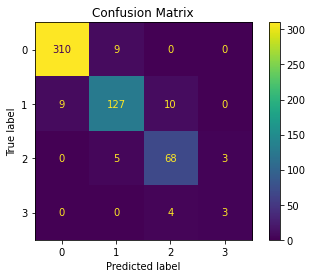

In [32]:
# Confusion Matrix
conf_mat = confusion_matrix(y_val, y_val_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_mat)
disp.plot()
plt.title("Confusion Matrix")
plt.show()

In [34]:
X_test_processed = preprocessor.transform(X_test)
y_test_pred = best_pipeline.predict(X_test)
output_df = pd.DataFrame({'id': test_df['id'], 'sii': y_test_pred})
output_df

,id,sii
0,00008ff9,1
1,000fd460,0
2,00105258,0
3,00115b9f,0
4,0016bb22,1
5,001f3379,1
6,0038ba98,0
7,0068a485,1
8,0069fbed,1
9,0083e397,1
